In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [32]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import talib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

# Loading the Data Sets from the API:

In [33]:
columns_rename = {'time':'datetime','open':'first','high':'high','low':'low','close':'last','volume':'volume'}

In [34]:
def check_na(df):
    for col in df:
        print("count of NA values in",col,":",str(df[col].isnull().sum()))
        print("\n")

def check_unique(df):
    for col in df:
        print("unique values in",col,":",str(df[col].unique()))
        print("\n")
        
def convert_float(df,col_list):
    for i in col_list:
        df[i] = df[i].astype('float')

def intra_day():
    import pandas as pd
    import requests
    import csv
    # Prompt the user for input
    symbols = input('Enter symbols separated by commas: ').split(',')
    dfs = []
    for symbol in symbols:
        url = 'https://www.alphavantage.co/query'
        params = {
            'function': 'TIME_SERIES_INTRADAY',
            'symbol': symbol,
            'interval': '1min',
            'apikey': 'OX2BPYPUY81XL6PJ',
            'outputsize': 'full',  # Include full historical data
            'start_date': '2022-03-01',  # Set the start date
            'end_date': '2022-03-01'  # Set the end date
        }
        
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            # Convert the data to a DataFrame
            df = pd.DataFrame.from_dict(data['Time Series (1min)'], orient='index')
            df = df.reset_index()
            df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
            df['datetime'] = pd.to_datetime(df['datetime'])
            df = df.sort_values('datetime')
            df['symbol'] = symbol  # Add a new column with the symbol
            df['fwd1min'] = df['close'].shift(-1)  # Add a new column with the 1-minute forward price
            dfs.append(df)
        else:
            print(f'Request failed with status code {response.status_code}')
    data = pd.concat(dfs, ignore_index = True)
    return(data)
    
def api_intra_day_extended(symbol):
    import requests
    import csv
    import pandas as pd
    
    #print(symbols)
    year = [1, 2]
    months = list(range(1, 13))
    permutations = len(year) * len(months)
    i = 1
    
    dfs = []
    for y in year:
        for m in months:
            print('------------------ progress:' + str(round(i*100/permutations,0)) + '% ------------------')
            i += 1
            url = 'https://www.alphavantage.co/query'
            slice_key = 'year'+str(y)+'month'+str(m)
            params = {
                'function': 'TIME_SERIES_INTRADAY_EXTENDED',
                'symbol': symbol,
                'interval': '1min',
                'apikey': 'TDJCJMSABXYSLRSP',
                'slice': slice_key
                #'outputsize': 'full',  # Include full historical data
            }
            response = requests.get(url, params=params)
    
            with requests.Session() as s:
                download = s.get(url,params=params)
                decoded_content = download.content.decode('utf-8')
                cr = csv.reader(decoded_content.splitlines(), delimiter=',')
                data = list(cr)
                df = pd.DataFrame(data[1:], columns=data[0])  # Create pandas DataFrame
                #print(slice_key)
                #print(pd.DataFrame(df).head(1))
                #print(pd.DataFrame(df).tail(1))
                #print('\n')
                df['ticker'] = symbol  # Add symbol column to DataFrame
                dfs.append(df)  # Append DataFrame to list of DataFrames
    
    data = pd.concat(dfs)  # Combine list of DataFrames into one DataFrame
    return(data)

def get_dataset():
    dfs_raw = []
    symbols = input('Enter symbols separated by commas: ').split(',')
    for i in symbols:
        print('----------------- ',i,': ----------------- ')
        dfs_raw.append(api_intra_day_extended(i))
        
    data = pd.concat(dfs_raw)  # Combine list of DataFrames into one DataFrame
        
    ## ADD DATA SANITY CHECKS HERE:
    # Comparison of total days vs. days fetched.
    # Comparison of count before and after dropping NAs. 
        
    data = (data.dropna()
            .rename(columns=columns_rename))
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['date'] = data['datetime']
    convert_float(data,['first','low','last','volume','high'])
    data = data.set_index(['ticker','datetime'])
    data = data.dropna()
    
    return(data)

In [35]:
df = get_dataset()

Enter symbols separated by commas: GOOGL,MSFT
-----------------  GOOGL : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
---------

In [36]:
print(df['date'].min())
print(df['date'].max())
df.info()
## issue: returning only 1 years data

2021-04-19 04:03:00
2023-04-06 20:00:00
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551458 entries, ('GOOGL', Timestamp('2023-04-06 20:00:00')) to ('MSFT', Timestamp('2021-04-19 04:03:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   first   551458 non-null  float64       
 1   high    551458 non-null  float64       
 2   low     551458 non-null  float64       
 3   last    551458 non-null  float64       
 4   volume  551458 non-null  float64       
 5   date    551458 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 38.4+ MB


# Feature Engineering

In [37]:
by_ticker = df.sort_index().groupby('ticker', group_keys=False)
by_ticker_date = df.sort_index().groupby(['ticker', 'date'])

In [38]:
data = pd.DataFrame(index=df.index)

In [39]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551458 entries, ('GOOGL', Timestamp('2023-04-06 20:00:00')) to ('MSFT', Timestamp('2021-04-19 04:03:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   date    551458 non-null  int64
dtypes: int64(1)
memory usage: 17.4+ MB


In [41]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('datetime').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

## Lagged Returns

In [42]:
data['ret1min'] = df['last'].div(df['first']).sub(1)
data['ret2min'] = df['last'].div(df['first'].shift(1)).sub(1)
data['ret3min'] = df['last'].div(df['first'].shift(2)).sub(1)
data['ret4min'] = df['last'].div(df['first'].shift(3)).sub(1)
data['ret5min'] = df['last'].div(df['first'].shift(4)).sub(1)
data['ret6min'] = df['last'].div(df['first'].shift(5)).sub(1)
data['ret7min'] = df['last'].div(df['first'].shift(6)).sub(1)
data['ret8min'] = df['last'].div(df['first'].shift(7)).sub(1)
data['ret9min'] = df['last'].div(df['first'].shift(8)).sub(1)
data['ret10min'] = df['last'].div(df['first'].shift(9)).sub(1)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551458 entries, ('GOOGL', Timestamp('2023-04-06 20:00:00')) to ('MSFT', Timestamp('2021-04-19 04:03:00'))
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      551458 non-null  int64  
 1   minute    551458 non-null  int32  
 2   ret1min   551458 non-null  float64
 3   ret2min   551457 non-null  float64
 4   ret3min   551456 non-null  float64
 5   ret4min   551455 non-null  float64
 6   ret5min   551454 non-null  float64
 7   ret6min   551453 non-null  float64
 8   ret7min   551452 non-null  float64
 9   ret8min   551451 non-null  float64
 10  ret9min   551450 non-null  float64
 11  ret10min  551449 non-null  float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 61.6+ MB


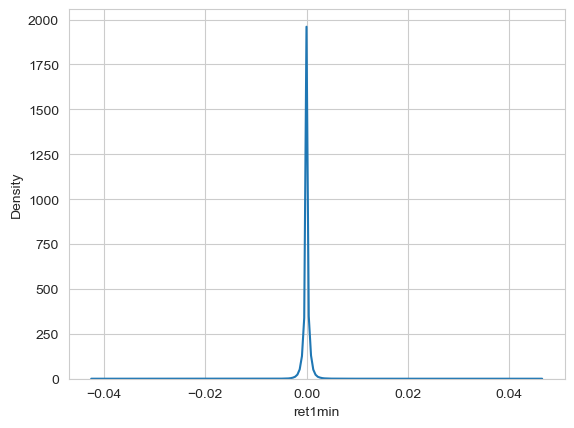

In [44]:
sns.kdeplot(data.ret1min);

In [45]:
data.ret1min.describe(percentiles=np.arange(.1, 1, .1)).iloc[1:].apply(lambda x: f'{x:.3%}')

mean    -0.000%
std      0.082%
min     -4.235%
10%     -0.070%
20%     -0.036%
30%     -0.016%
40%     -0.001%
50%      0.000%
60%      0.000%
70%      0.016%
80%      0.035%
90%      0.069%
max      4.637%
Name: ret1min, dtype: object

In [46]:
print(f'Skew: {data.ret1min.skew():.2f} | Kurtosis: {data.ret1min.kurtosis():.2f}')

Skew: 0.11 | Kurtosis: 187.56


In [47]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

date  minute   ret1min   ret2min   ret3min  \
ticker datetime                                                            
GOOGL  2021-04-27 17:02:00    4087     781  0.046369  0.000923  0.000735   
MSFT   2022-07-26 18:05:00  199903     844  0.041783  0.003957 -0.003052   
GOOGL  2023-02-01 16:40:00  293498     759  0.039032 -0.000096 -0.000096   
MSFT   2021-04-27 17:02:00    4087     781  0.036725  0.035741  0.037094   
GOOGL  2022-11-10 08:31:00  254510     270  0.031963 -0.001326 -0.008011   
MSFT   2022-12-13 08:31:00  268977     270  0.030895 -0.000151  0.003675   
       2022-06-02 09:04:00  176221     303  0.029173  0.000544  0.025348   
       2022-03-09 08:01:00  138227     240  0.029001  0.000000  0.000106   
       2023-01-24 16:02:00  288804     721  0.028798 -0.002364 -0.015810   
GOOGL  2022-02-01 16:06:00  121921     725  0.028571 -0.001290  0.002496   

                             ret4min   ret5min   ret6min   ret7min   ret8min  \
ticker datetime                                                                
GOOGL  2021-04-27 17:02:00  0.001759  0.001429  0.001759  0.003857  0.003017   
MSFT   2022-07-26 18:05:00 -0.008199 -0.009064 -0.019512 -0.019512 -0.023214   
GOOGL  2023-02-01 16:40:00 -0.000096 -0.000957 -0.002390 -0.002867 -0.002962   
MSFT   2021-04-27 17:02:00  0.036315  0.035455  0.035823  0.035946  0.035659   
GOOGL  2022-11-10 08:31:00  0.001884 -0.003528 -0.005610 -0.008772 -0.011482   
MSFT   2022-12-13 08:31:00  0.015096  0.013155  0.013969  0.012729  0.017826   
       2022-06-02 09:04:00  0.036714  0.025729  0.027486  0.033258  0.035780   
       2022-03-09 08:01:00  0.000458  0.000564  0.000882  0.001235 -0.000106   
       2023-01-24 16:02:00 -0.015810 -0.013432 -0.013861 -0.018874 -0.018410   
GOOGL  2022-02-01 16:06:00  0.009793 -0.007170 -0.017966 -0.025710 -0.025921   

                             ret9min  ret10min       first        last  
ticker datetime                                                         
GOOGL  2021-04-27 17:02:00  0.002597  0.002601  114.549000  119.860500  
MSFT   2022-07-26 18:05:00 -0.020982 -0.018850  248.956645  259.358789  
GOOGL  2023-02-01 16:40:00 -0.002867 -0.003724  100.430000  104.350000  
MSFT   2021-04-27 17:02:00  0.035495  0.035864  248.178888  257.293218  
GOOGL  2022-11-10 08:31:00 -0.010941 -0.009532   87.600000   90.400000  
MSFT   2022-12-13 08:31:00  0.013232  0.014590  256.352741  264.272744  
       2022-06-02 09:04:00  0.034343  0.033917  266.068568  273.830473  
       2022-03-09 08:01:00  0.000106  0.001234  273.134201  281.055439  
       2023-01-24 16:02:00 -0.019685 -0.016588  241.420443  248.372889  
GOOGL  2022-02-01 16:06:00 -0.023066 -0.022400  140.000000  144.000000

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551458 entries, ('GOOGL', Timestamp('2023-04-06 20:00:00')) to ('MSFT', Timestamp('2021-04-19 04:03:00'))
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      551458 non-null  int64  
 1   minute    551458 non-null  int32  
 2   ret1min   551458 non-null  float64
 3   ret2min   551457 non-null  float64
 4   ret3min   551456 non-null  float64
 5   ret4min   551455 non-null  float64
 6   ret5min   551454 non-null  float64
 7   ret6min   551453 non-null  float64
 8   ret7min   551452 non-null  float64
 9   ret8min   551451 non-null  float64
 10  ret9min   551450 non-null  float64
 11  ret10min  551449 non-null  float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 77.7+ MB


## Forward Returns

In [49]:
data['fwd1min'] = (data.sort_index())['ret1min'].shift(-1)

In [50]:
data = data.dropna(subset=['fwd1min'])

In [51]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551457 entries, ('GOOGL', Timestamp('2023-04-06 20:00:00')) to ('MSFT', Timestamp('2021-04-19 04:03:00'))
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      551457 non-null  int64  
 1   minute    551457 non-null  int32  
 2   ret1min   551457 non-null  float64
 3   ret2min   551456 non-null  float64
 4   ret3min   551455 non-null  float64
 5   ret4min   551454 non-null  float64
 6   ret5min   551453 non-null  float64
 7   ret6min   551452 non-null  float64
 8   ret7min   551451 non-null  float64
 9   ret8min   551450 non-null  float64
 10  ret9min   551449 non-null  float64
 11  ret10min  551448 non-null  float64
 12  fwd1min   551457 non-null  float64
dtypes: float64(11), int32(1), int64(1)
memory usage: 65.8+ MB


In [52]:
df.tail()

first        high         low        last  \
ticker datetime                                                              
MSFT   2021-04-19 05:12:00  255.977141  256.340535  255.977141  256.340535   
       2021-04-19 04:18:00  256.045891  256.045891  256.045891  256.045891   
       2021-04-19 04:11:00  256.045891  256.045891  256.045891  256.045891   
       2021-04-19 04:04:00  256.340535  256.340535  256.340535  256.340535   
       2021-04-19 04:03:00  256.340535  256.340535  256.340535  256.340535   

                            volume                date  
ticker datetime                                         
MSFT   2021-04-19 05:12:00  1707.0 2021-04-19 05:12:00  
       2021-04-19 04:18:00   573.0 2021-04-19 04:18:00  
       2021-04-19 04:11:00   182.0 2021-04-19 04:11:00  
       2021-04-19 04:04:00   163.0 2021-04-19 04:04:00  
       2021-04-19 04:03:00   514.0 2021-04-19 04:03:00

## Other Technical Features:

In [53]:
data['BOP'] = talib.BOP(df['first'],df['high'],df['low'],df['last'])

In [54]:
data['CCI'] = talib.CCI(df.high,df.low,df['last'],timeperiod=14)

In [55]:
data['MFI'] = talib.MFI(df.high,df.low,df['last'],df.volume,timeperiod=14)

In [56]:
data[['BOP', 'CCI', 'MFI']].describe(deciles)

,BOP,CCI,MFI
count,551457.000000,551444.000000,5.514430e+05
mean,-0.001787,-0.954923,4.980334e+01
std,0.606117,107.969027,1.865777e+01
min,-1.000000,-466.666667,-4.766855e-13
10%,-0.906250,-138.806969,2.567435e+01
20%,-0.619048,-101.022043,3.393763e+01
30%,-0.344304,-70.465339,3.993435e+01
40%,-0.029557,-38.476298,4.504421e+01
50%,0.000000,-1.028298,4.983191e+01
60%,0.012308,36.623167,5.459299e+01


In [57]:
data['STOCHRSI'] = talib.STOCHRSI(df['last'].ffill(),timeperiod=14,fastk_period=14,fastd_period=3,fastd_matype=0)[0]

In [58]:
fastk_period=14
slowk_period=3
slowk_matype=0
slowd_period=3
slowd_matype=0
data['slowk'], data['slowd'] = talib.STOCH(df.high.ffill(), df.low.ffill(), df['last'].ffill(), 
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)

In [59]:
data['NATR'] = talib.NATR(df.high.ffill(),df.low.ffill(),df['last'].ffill())

In [60]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551457 entries, ('GOOGL', Timestamp('2023-04-06 20:00:00')) to ('MSFT', Timestamp('2021-04-19 04:03:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      551457 non-null  int64  
 1   minute    551457 non-null  int32  
 2   ret1min   551457 non-null  float64
 3   ret2min   551456 non-null  float64
 4   ret3min   551455 non-null  float64
 5   ret4min   551454 non-null  float64
 6   ret5min   551453 non-null  float64
 7   ret6min   551452 non-null  float64
 8   ret7min   551451 non-null  float64
 9   ret8min   551450 non-null  float64
 10  ret9min   551449 non-null  float64
 11  ret10min  551448 non-null  float64
 12  fwd1min   551457 non-null  float64
 13  BOP       551457 non-null  float64
 14  CCI       551444 non-null  float64
 15  MFI       551443 non-null  float64
 16  STOCHRSI  551428 non-null  float64
 17  slowk     551440 non-null  float64
 18  slowd 

# Evaluate features

In [61]:
features = ['ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min', 
            'ret6min', 'ret7min', 'ret8min', 'ret9min', 'ret10min','BOP', 'CCI', 'MFI', 'STOCHRSI', 
            'slowk', 'slowd']

In [62]:
sample = data.sample(n=20000)

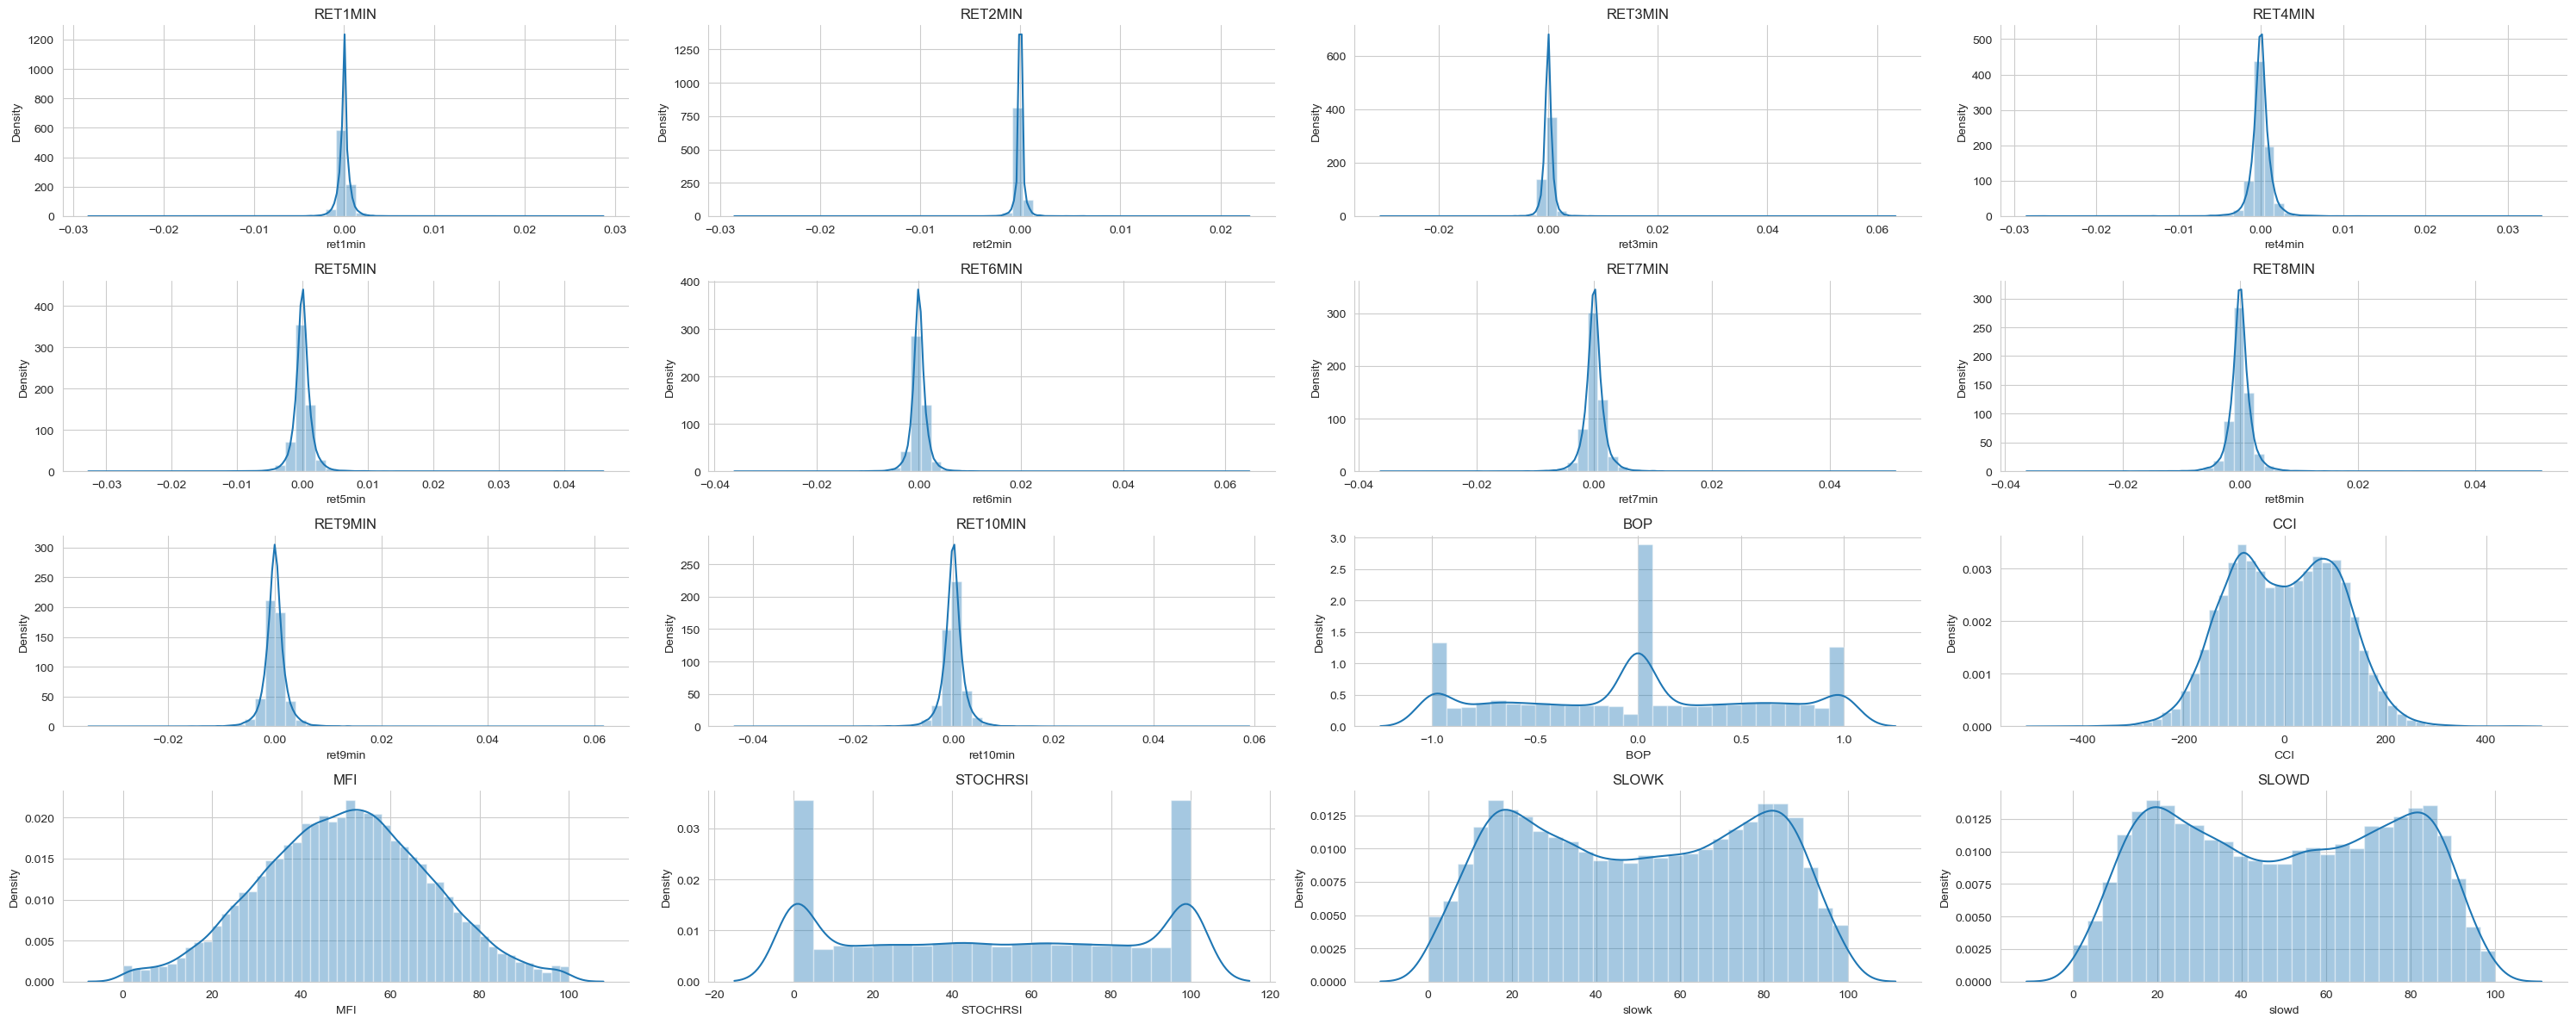

In [63]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(30, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.distplot(sample[feature], ax=axes[i])
    axes[i].set_title(feature.upper())
    
sns.despine()
fig.tight_layout()

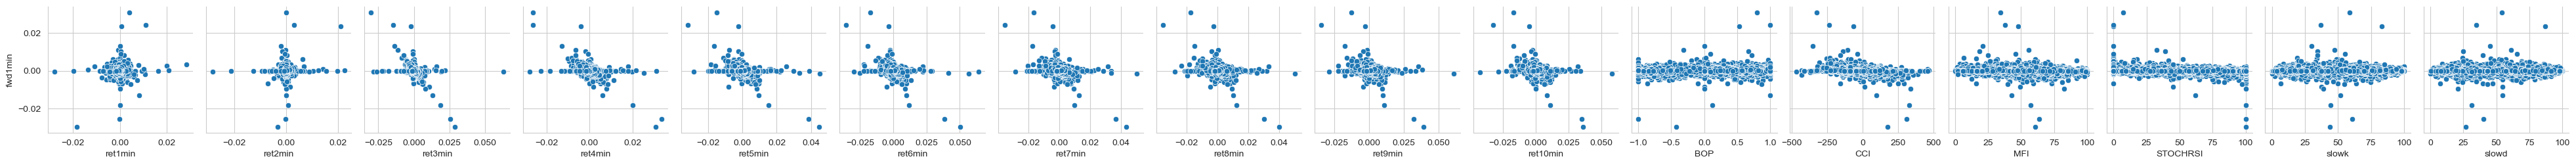

In [64]:
sns.pairplot(sample, y_vars=['fwd1min'], x_vars=features)

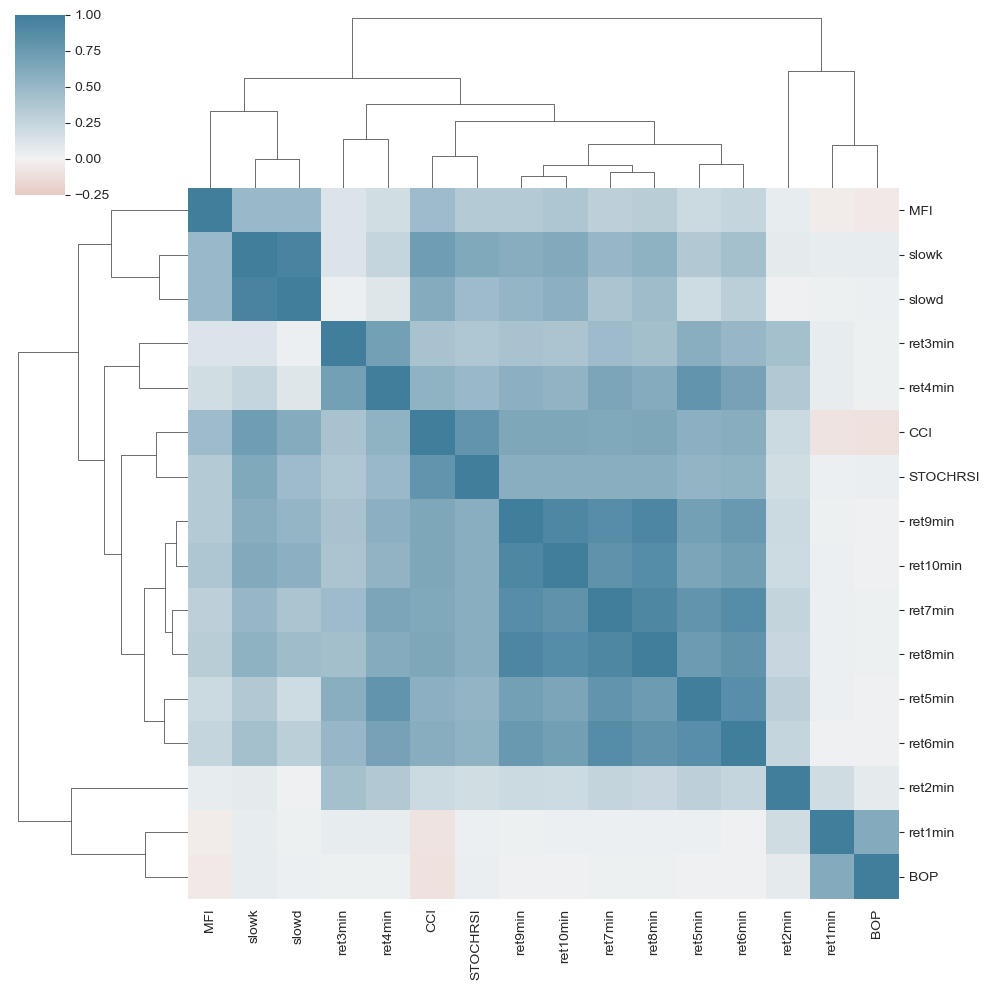

In [65]:
corr = sample.loc[:, features].corr()
sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0, vmin=-.25);

In [66]:
ic = {}
for feature in tqdm(features):
    df = data[['fwd1min', feature]].dropna()
    by_day = df.groupby(df.index.get_level_values('datetime').date) # calc per min is very time-consuming
    ic[feature] = by_day.apply(lambda x: spearmanr(x.fwd1min, x[feature])[0]).mean()
ic = pd.Series(ic)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


In [67]:
ic.sort_values()

ret3min    -0.717643
ret4min    -0.508931
STOCHRSI   -0.423880
ret5min    -0.416151
CCI        -0.389021
ret6min    -0.360895
ret7min    -0.323050
ret8min    -0.296266
ret9min    -0.275177
ret10min   -0.256702
MFI        -0.152527
slowk      -0.065692
ret1min     0.000923
slowd       0.002403
BOP         0.003010
ret2min     0.008242
dtype: float64

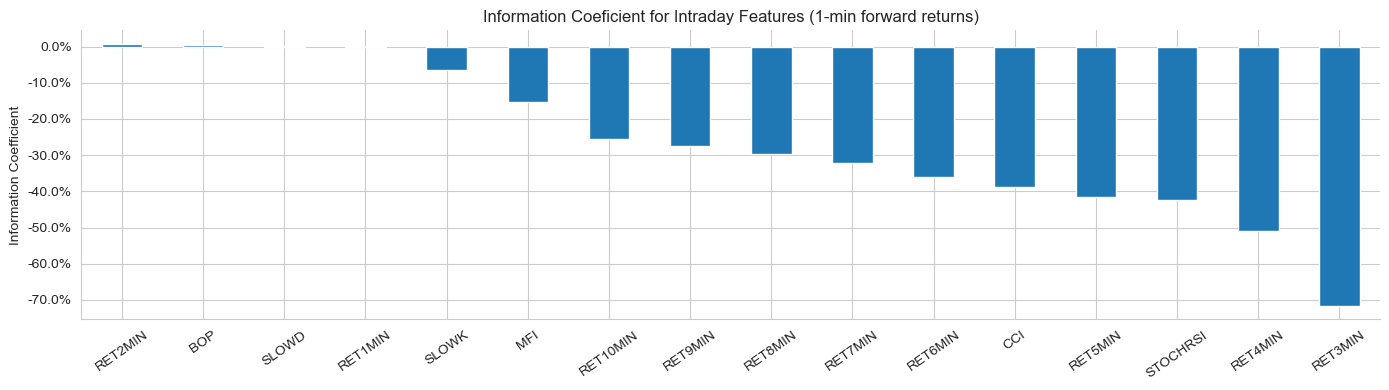

In [68]:
title = 'Information Coeficient for Intraday Features (1-min forward returns)'
ic.index = ic.index.map(str.upper)
ax = ic.sort_values(ascending=False).plot.bar(figsize=(14, 4), title=title, rot=35)
ax.set_ylabel('Information Coefficient')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
sns.despine()
plt.tight_layout();

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551457 entries, ('GOOGL', Timestamp('2023-04-06 20:00:00')) to ('MSFT', Timestamp('2021-04-19 04:03:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      551457 non-null  int64  
 1   minute    551457 non-null  int32  
 2   ret1min   551457 non-null  float64
 3   ret2min   551456 non-null  float64
 4   ret3min   551455 non-null  float64
 5   ret4min   551454 non-null  float64
 6   ret5min   551453 non-null  float64
 7   ret6min   551452 non-null  float64
 8   ret7min   551451 non-null  float64
 9   ret8min   551450 non-null  float64
 10  ret9min   551449 non-null  float64
 11  ret10min  551448 non-null  float64
 12  fwd1min   551457 non-null  float64
 13  BOP       551457 non-null  float64
 14  CCI       551444 non-null  float64
 15  MFI       551443 non-null  float64
 16  STOCHRSI  551428 non-null  float64
 17  slowk     551440 non-null  float64
 18  slowd 

In [70]:
path = 'C:/Users/ameen/Desktop/gigs/trading_bot_python_2_april_23'
data.drop(['date'], axis=1).to_csv(path + '/dataset.csv')